# Tutorial: How to Query LLMs / Pitfalls in Prompting / Caution in Prompting
In this tutorial, we present some hands-on examples of how to query large language models (LLMs) and discuss some pitfalls in prompting. While we use smaller models such as `gemma-2-2b` that are compatible with the GPU available in Colab, the principles apply to other bigger LLMs as well.

## Setup
Before we start, please make sure to configure the notebook to use a GPU. You can do this by going to `Runtime` -> `Change runtime type` and selecting `(T4) GPU` as the hardware accelerator.

Next, we will install the `transformers` library, which provides a simple interface to query LLMs.

In [1]:
!pip install transformers torch huggingface_hub

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import notebook_login
import torch

/mounts/Users/student/xinpeng/.conda/envs/prune/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


### Login
In this tutorial, we will use HuggingFace's [transformers](https://huggingface.co/docs/transformers/index) to interact with LLMs.

To load a model, we use the [HuggingFace Hub](https://huggingface.co/docs/hub/index), a platform that allows practitioners to share their latest models. Please execute the following code cell and provide your access token to connect to the HuggingFace Hub.

Note: if you do not yet have a HuggingFace access token, you can create an account and generate one. Detailed instructions are available [here](https://huggingface.co/docs/hub/en/security-tokens).

<strong>  Important </strong>: When creating tokens, make sure to open the opion :

`Read access to contents of all public gated repos you can acces`

In [3]:
notebook_login()

## Loading a Large Language Model
Once you have successfully logged in, you can start downloading models from the [HuggingFace Hub](https://huggingface.co/models). In this tutorial, we are going to work with Google's `gemma-2-2b` model, a smaller LLM with 2B parameters.

Let us first load the model from the hub by running the cell below. This might take a while. In the meantime, you can explore the [model card](https://huggingface.co/google/gemma-2-2b) of `gemma-2-2b`. It shows you details about the model, such as its architecture, training data, and how to use it.

In [4]:
base_model_name = "google/gemma-2-2b"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

To pre-process text into a format that the model understands, we also need to load a [tokenizer](https://huggingface.co/docs/transformers/tokenizer_summary). Most models have their own tokenizer. Thus, you need to specify the model's name to load the correct one.

In [5]:
base_model_tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)

## Input: Prompting
Now that we have downloaded the model and its respective tokenizer, we can interact with it.

### Tokenization
Let us define a simple prompt and convert it into a format that the model understands. For this, we use the tokenizer downloaded previously.

In [6]:
input_text = "I think the SurvAI day is"
input_ids = base_model_tokenizer(input_text, return_tensors="pt").to("cuda")
for i in input_ids['input_ids'][0]:
  print(f'"{base_model_tokenizer.decode(i)}"')

"<bos>"
"I"
" think"
" the"
" Surv"
"AI"
" day"
" is"


As you can see, the tokenizer splits the sentence into multiple sub-words. For each subword, it then creates a `token ID` that corresponds to a vector in the model's vocabulary. Furthermore, a beginning-of-sentence `<bos>` token is prepended, which indicates the beginning of sentence. See what actually goes into the model:

In [7]:
input_ids['input_ids']

tensor([[     2, 235285,   1742,    573, 169927,  11716,   1744,    603]],
       device='cuda:0')

### Simple Prompting
Let us now pass the input to the model.

In [8]:
outputs = base_model.generate(**input_ids, max_new_tokens=4)
outputs

tensor([[     2, 235285,   1742,    573, 169927,  11716,   1744,    603,    476,
           1775,   4268, 235265]], device='cuda:0')


The output of the model is again a tensor of token IDs. We use the model's tokenizer to decode it back into natural language. As you can see, the output consists of the input text as well as the model's completion:

In [9]:
print(base_model_tokenizer.decode(outputs[0]))

<bos>I think the SurvAI day is a great idea.


However, the base model is not trained to follow instructions or answer questions in a multi-turn chat style. It is desigend to do text completion. For instance, see the model response to the question below:

In [10]:
input_text = "How are you today?"
input_ids = base_model_tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = base_model.generate(**input_ids, max_new_tokens=4)
print(base_model_tokenizer.decode(outputs[0]))

<bos>How are you today?

I hope you


### Prompting Instruction-Tuned LLMs
The model loaded so far is a base model that is trained using unsupervised pre-training. Thus, it is best for text-completion. However, there exists also an instruct version of `gemma-2-2b`, specifically `gemma-2-2b-it`. This model is further fine-tuned to follow instructions. See [here](https://huggingface.co/google/gemma-2-2b-it) for the model card.

Let us now download the instruction-tuned model and its respective tokenizer.

In [11]:
# empty cache
torch.cuda.empty_cache()

it_model_name = "google/gemma-2-2b-it"
it_model = AutoModelForCausalLM.from_pretrained(
    it_model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
it_model_tokenizer = AutoTokenizer.from_pretrained(it_model_name, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Again we define some input prompt and tokenize it. For instruction-tuned model, we are going to wrap into a chat template first. This ensures that the input prompt follows the instruction style of the data the model was fine-tuned on. For example, below we indicate that the user is prompting the model.

In [12]:
messages = [
    {"role": "user", "content": "How to bridge Natural Language Processing (NLP) and Survey Research?"},
]
input_ids = it_model_tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")


The exact template depends on the model you use. For the Gemma2 model, it is:
```
<start_of_turn>user
{{ if .System }}{{ .System }} {{ end }}{{ .Prompt }}<end_of_turn>
<start_of_turn>model
{{ .Response }}<end_of_turn>
```

Thus, the final input to the model is:

In [13]:
it_model_tokenizer.decode(input_ids['input_ids'][0], skip_special_tokens=False)

'<bos><start_of_turn>user\nHow to bridge Natural Language Processing (NLP) and Survey Research?<end_of_turn>\n'

Given such a prompt, the model will generate its answer after the `<end_of_turn>` token. For its response, run the cell below.

In [14]:
outputs = it_model.generate(**input_ids, max_new_tokens=256)
print(it_model_tokenizer.decode(outputs[0]))

<bos><start_of_turn>user
How to bridge Natural Language Processing (NLP) and Survey Research?<end_of_turn>
* **Understanding the Challenges:**
    * **Data Collection:** NLP can be used to analyze large amounts of text data, but survey data is often structured and requires specific formats.
    * **Data Interpretation:** NLP models can be complex and require expertise to interpret their outputs. Survey data is often qualitative and requires careful analysis.
    * **Bias and Fairness:** NLP models can be biased, and it's important to be aware of this when using them in survey research.
    * **Privacy and Confidentiality:** Survey data is sensitive, and it's important to protect the privacy of respondents.

* **Potential Applications:**
    * **Automated Question Generation:** NLP can be used to generate survey questions based on a specific topic or research question.
    * **Survey Question Analysis:** NLP can be used to analyze survey questions for clarity, bias, and other factors.
 

As you can see, the instruction-tuned model can understand the instruction and give you a sensible answer.

### Prompting Strategies
In this section, we will introduce several common prompting techniques:
- Vanilla Prompt
- Zero-shot-COT
- Persona Prompt

#### Vanilla Prompting

Vanilla prompting is the standard form of prompting as we have seen it so far. Note that the model tends to give you the answer more directly if you clearly express the instructions of your query. For some questions (such as the one below), you will see the model responding with intermediate reasoning steps, since particularly newer models have been trained to answer in intemediate steps before outputing the final answer. 

In [15]:
messages = [
  {"role": "user", "content": "9.11 and 9.8, which one is larger?"},
]
input_ids = it_model_tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")
outputs = it_model.generate(**input_ids, max_new_tokens=256)
print(it_model_tokenizer.decode(outputs[0]))

<bos><start_of_turn>user
9.11 and 9.8, which one is larger?<end_of_turn>


Here's how to figure this out:

* **9.11** is a decimal number.
* **9.8** is also a decimal number.

**To compare, we need to know what kind of comparison you're looking for:**

* **Larger in terms of magnitude:**  9.11 is larger than 9.8.
* **Larger in terms of a specific context:**  You need to provide more information about the context. 

**Please clarify your question!** 
<end_of_turn>


as you can see, the model is wrong about this simple question with vanilla prompting.

### Zero-shot Chain-of-Thought (COT) Prompting
Adding a simple "Let's think step by step." at the end of question can help the model to produce multiple reasoning steps to arrive at the final answer.

In [16]:
messages = [
  {"role": "user", "content": "9.11 and 9.8, which one is larger? Let's think step by step."},
]
input_ids = it_model_tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")
outputs = it_model.generate(**input_ids, max_new_tokens=256)
print(it_model_tokenizer.decode(outputs[0]))

<bos><start_of_turn>user
9.11 and 9.8, which one is larger? Let's think step by step.<end_of_turn>


**Step 1: Understand the units.**

* 9.11 is a decimal number.
* 9.8 is also a decimal number.

**Step 2: Compare the digits.**

* Both numbers have the same number of digits after the decimal point.

**Step 3: Compare the digits in the whole number part.**

* 9 is larger than 9.

**Step 4: Compare the digits in the decimal part.**

* 1 is smaller than 8.

**Step 5: Combine the information from steps 3 and 4.**

* Since 9 is larger than 9.8, the number 9.11 is smaller than 9.8.


**Answer:** 9.8 is larger. 
<end_of_turn>


The model starts to reason in intermediate as shown above. Hower, the reasoning process may not be correct, which is a common issue especially for smaller LLMs.

You can also use the prompt template to do multi-turn prompting, essentially simulating a conversation. This technique is often used to guide the model's behavior via few-shot examples.

In [17]:
messages = [
  {"role": "user", "content": "Hello, how are you?"},
  {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
  {"role": "user", "content": "9.11 and 9.8, which one is larger?"},
]
input_ids = it_model_tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")
outputs = it_model.generate(**input_ids, max_new_tokens=256)
print(it_model_tokenizer.decode(outputs[0]))

<bos><start_of_turn>user
Hello, how are you?<end_of_turn>
<start_of_turn>model
I'm doing great. How can I help you today?<end_of_turn>
<start_of_turn>user
9.11 and 9.8, which one is larger?<end_of_turn>
9.11 and 9.8 are both numbers, but they are different types of numbers. 9.11 is a decimal number, while 9.8 is a whole number. 

Here's why:

* **Decimal numbers** have a decimal point, indicating a fractional part. 9.11 means 9 plus 0.11.
* **Whole numbers** are numbers without any fractional part. 9.8 is a whole number, but it's a decimal number. 

So, 9.11 is larger than 9.8. 



<end_of_turn>


### Persona Prompt with System Prompt
![image.png](assets/imgs/persona.png)

Finally, it is possible to use the model's system prompt to align the model's behavior with a certain persona. The table above illustrates examples of how to prompt the model towards a certain persona.

In [18]:
system_prompt = "You are a university professor. You are also very engergetic and funny. \n"

messages = [
    # {"role": "system", "content": system_prompt}, # Unlike Llama2, Gemma2 model doesn't really support system role.
    {"role": "user", "content": system_prompt + "How to bridge Natural Language Processing (NLP) and Survey Research?"},
]
input_ids = it_model_tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")
outputs = it_model.generate(**input_ids, max_new_tokens=256)
print(it_model_tokenizer.decode(outputs[0]))

<bos><start_of_turn>user
You are a university professor. You are also very engergetic and funny. 
How to bridge Natural Language Processing (NLP) and Survey Research?<end_of_turn>
* **What are the key challenges?**
* **What are some potential solutions?**
* **What are some exciting applications?**

Alright, class, settle down, settle down! Today we're diving into a topic that's as exciting as a unicorn riding a unicycle through a rainbow – NLP and Survey Research! 

Now, you might be thinking, "Professor, what's the big deal?" Well, my friends, it's like this: NLP is all about understanding human language, and survey research is all about understanding human opinions.  Imagine a world where you could ask a question in plain English, and NLP could analyze the response, understand the sentiment, and even extract key information like demographics or opinions on a specific topic. That's the magic of NLP and survey research working together!

**Challenges, you ask?**

* **Data Cleaning:**  

### Generation Strategies
In this section, we will dig into the text generation and learn how different gerenation setups can influence the model output.

#### Greedy Search
In greedy search, model will select the token with the highest probability in the next token posisition. 

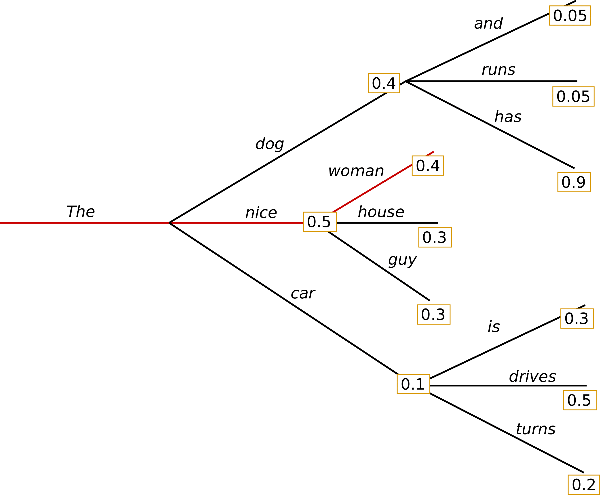

In [19]:
# encode context the generation is conditioned on
messages = [
    {"role": "user", "content": "How to bridge Natural Language Processing (NLP) and Survey Research?"},
]
input_ids = it_model_tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")
greedy_output = it_model.generate(**input_ids, max_new_tokens=256)

print("Output:\n" + 100 * '-')
print(it_model_tokenizer.decode(greedy_output[0], skip_special_tokens=True))


Output:
----------------------------------------------------------------------------------------------------
user
How to bridge Natural Language Processing (NLP) and Survey Research?
* **Understanding the Challenges:**
    * **Data Collection:** NLP can be used to analyze large amounts of text data, but survey data is often structured and requires specific formats.
    * **Data Interpretation:** NLP models can be complex and require expertise to interpret their outputs. Survey data is often qualitative and requires careful analysis.
    * **Bias and Fairness:** NLP models can be biased, and it's important to be aware of this when using them in survey research.
    * **Privacy and Confidentiality:** Survey data is sensitive, and it's important to protect the privacy of respondents.

* **Potential Applications:**
    * **Automated Question Generation:** NLP can be used to generate survey questions based on a specific topic or research question.
    * **Survey Question Analysis:** NLP can

#### Beam Search
The model will keep track of multiple tokens in the sequence, and select the one sequence with the overall highest probability.

For example, beam search keeps track of the most likely sequence "The nice", and also keep track of the second most likely one "The dog". 

At the next time step, beam search realizes that the sequence "The dog has" is the sequence with highest probability.

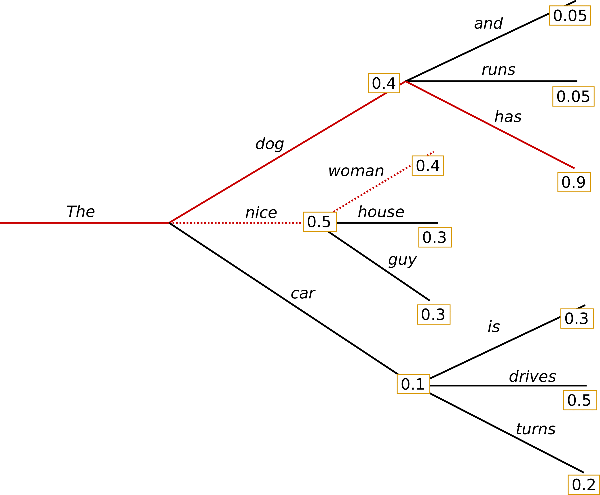

In [20]:
beam_output = it_model.generate(
    **input_ids,
    max_new_tokens=128,
    num_beams=5,  # using beam search, how many beams to keep at each step
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(it_model_tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
user
How to bridge Natural Language Processing (NLP) and Survey Research?


## Bridging NLP and Survey Research: A Powerful Partnership

Natural Language Processing (NLP) and Survey Research can be powerful allies, each bringing unique strengths to the table. 

**Here's how they can be bridged:**

**1. Automating Data Collection and Analysis:**

* **Question Generation:** NLP can be used to automatically generate survey questions based on pre-defined topics, target audience, and research objectives. This can save time and effort, especially for large-scale surveys.
* **Data Cleaning and Preprocessing:** NLP techniques like text normalization, stemming, and lemmatization can be used to clean


### Sampling
The generation process above is **deterministic**.

Instead of selecting the most likely word or sequence, we can also sample from the probability distribution over the vocabulary to introduce randomness.

This will make the generation probablistic and diverse.

There are two common sampling strategies:

- Top-K Sampling 
- Top-p (nucleus) Sampling



![sampling](assets/imgs/sampling_search_with_temp.png)

#### Top-K sampling
In Top-K sampling, the K most likely next words are filtered and the probability mass is redistributed among only those K next words

![top_k](assets/imgs/top_k_sampling.png)

In [21]:
sample_output = it_model.generate(
    **input_ids,
    max_new_tokens=128,
    do_sample=True,
    top_k=50 # using sampling, how many top-k tokens to sample from'
)

print("Output:\n" + 100 * '-')
print(it_model_tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
user
How to bridge Natural Language Processing (NLP) and Survey Research?


## Bridging NLP and Survey Research: Combining the Power of Data

NLP and survey research, while seemingly separate disciplines, actually have much in common and can complement each other tremendously when they come together. Here's how to bridge both with innovative techniques:

**1. Text Analysis for Improved Survey Design:**

- **Topic modeling:** Use NLP tools like LDA or TF-IDF to understand the hidden themes within survey questions and the responses they receive. This guides you towards more relevant and comprehensive questions. 
- **Sentiment analysis:** Gauge the emotional tone of survey responses to identify positive, negative, or neutral perspectives. This helps


#### Top-p (nucleus) sampling

Instead of sampling only from the most likely K words, in Top-p sampling chooses from the smallest possible set of words whose cumulative probability exceeds the probability p. 

The probability mass is then redistributed among this set of words. 

![top_p](assets/imgs/top_p_sampling.png)

In [22]:
sample_output = it_model.generate(
    **input_ids,
    max_new_tokens=128,
    do_sample=True,
    top_p=0.92, # top_p is an alternative to top_k, it sets the cumulative probability of the most likely tokens to sample from
    top_k=0
)

print("Output:\n" + 100 * '-')
print(it_model_tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
user
How to bridge Natural Language Processing (NLP) and Survey Research?
* **Challenges**: What are the main challenges in this field?
* **Solutions**: What are some potential solutions to these challenges?
* **Case Study**:  What is a good case study showing NLP and Survey Research integration? 
* **Future Outlook**: What are the future opportunities and challenges for this field?

## Bridging NLP and Survey Research

### Challenges

Integrating NLP and Survey Research is a relatively new frontier with several key challenges:

**1. Data Format and Compatibility:**
    * **Structure & Meaning:** Survey data is structured, with clear categories and predefined responses, while NLP models thrive on unstructured text


### Multiple Choice Question Evaluation
In this section, we will showcase how we evaluat LLM with multiple choice question.
As we have talked about in the turtorial, there is a mismatch problem due the different evaluation method:

- First token probabilites
- Text answer

The benefit of using first token probabilites is that it is eay to use and automatic evlaution. 

However, the first token probabilites may not neccessarily be the text answer.

![mcq](assets/imgs/mcq.png)

We first define our MCQ here and we can also add persona prompt if one wants the LLM to simulate certain group.

In [23]:
prompt ='''
You are female, from the South, having education level of college graduate or some postgrad. Please read the multiple-choice question below carefully and select ONE of the listed options and only give a single letter. \n
Question: How much, if at all, do you worry about the following happening to you? Not being able to pay your bills\n
A. Refused \n
B. Worry a lot \n
C. Do not worry at all \n
D. Worry a little \n
Answer:
'''

Since we want to get access to the model output, we can set `output_scores=True` to return the output score over the whole vocabulary.

In [24]:
messages = [
    {"role": "user", "content": prompt},
]
input_ids = it_model_tokenizer.apply_chat_template(messages, return_tensors="pt", return_dict=True).to("cuda")


output = it_model.generate(**input_ids, 
                           max_new_tokens=128, 
                           do_sample=False, 
                           return_dict_in_generate=True,  
                           output_scores=True # return the output scores
                           ) 

Specify the option IDs we care about, here we only have 'A' 'B' 'C' 'D' as option IDs.

In [25]:
alphabet = ['A', 'B', 'C', 'D']

Here, we need to know the token id of the letters, since we need to use them as an index to retrieve the corresponding model output score.

In [26]:
token_ids = {letter: it_model_tokenizer.encode(letter, add_special_tokens=False)[0] for letter in alphabet}

Now, we can retrieve the output score, we set `position_to_look=0` because we only want to look at the score at the first token position.

In [27]:
id_score_dict = {}
position_to_look = 0
for idx in range(len(alphabet)):
    id_score_dict[alphabet[idx]] = output.scores[position_to_look][-1][token_ids[alphabet[idx]]].item()


In [28]:
id_score_dict

{'A': 12.125, 'B': 8.125, 'C': 8.4375, 'D': 8.8125}

As you can see, we successfully retrieved the score, and it shows that 'A' is the one with the highest score. 

Therefore, using first token probabilites we will take 'A' as the model answer.

If we print out the how text output, we see the model may actually choose a different answer. 

In [29]:
response = it_model_tokenizer.decode(output.sequences[0], skip_special_tokens=False)
print(response)

<bos><start_of_turn>user
You are female, from the South, having education level of college graduate or some postgrad. Please read the multiple-choice question below carefully and select ONE of the listed options and only give a single letter. 

Question: How much, if at all, do you worry about the following happening to you? Not being able to pay your bills

A. Refused 

B. Worry a lot 

C. Do not worry at all 

D. Worry a little 

Answer:<end_of_turn>
**C** 
<end_of_turn>
